In [1]:
# Importing necessary libraries
from support.funcs import *
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pptx import Presentation
from pptx.util import Inches
import json
import os
from io import BytesIO
from scipy.signal import savgol_filter

# Read the JSON file containing the Session Directory
with open(r'C:\Users\arpan\OneDrive\Documents\PoseEstimation\upperbody\SessionDirectory.json', 'r') as file:
    session_data = json.load(file)

# Get the directory path from the JSON data
pth = session_data["directory"]

# getting mpipe data
df_mpipe=pd.read_csv(pth+'\\mpipe.csv')
df_mpipe

,epoch_time,LS_x,LS_y,LS_z,LE_x,LE_y,LE_z,LW_x,LW_y,LW_z,...,RS_z,RE_x,RE_y,RE_z,RW_x,RW_y,RW_z,TR_x,TR_y,TR_z
0,1.688727e+09,0.13933,0.360294,-0.467509,0.184816,0.131875,-0.308479,0.213480,-0.023526,-0.099521,...,-0.427628,-0.205886,0.119229,-0.263315,-0.170416,-0.021118,-0.034802,-0.025151,0.271785,-0.436575
1,1.688727e+09,0.13933,0.360294,-0.467509,0.188301,0.130733,-0.314895,0.213480,-0.023526,-0.099521,...,-0.419893,-0.206824,0.118184,-0.269089,-0.170416,-0.021118,-0.034802,-0.024621,0.272381,-0.428763
2,1.688727e+09,0.13933,0.360294,-0.467509,0.188301,0.130733,-0.314895,0.212018,-0.028917,-0.118984,...,-0.419893,-0.206824,0.118184,-0.269089,-0.171762,-0.020733,-0.043494,-0.024621,0.272381,-0.428763
3,1.688727e+09,0.13933,0.360294,-0.467509,0.188405,0.129666,-0.320819,0.211836,-0.024689,-0.114074,...,-0.419893,-0.205886,0.119229,-0.263315,-0.172534,-0.022011,-0.048302,-0.024372,0.272952,-0.422883
4,1.688727e+09,0.13933,0.360294,-0.467509,0.188018,0.134979,-0.308983,0.211836,-0.024689,-0.114074,...,-0.419893,-0.204964,0.120274,-0.257540,-0.171762,-0.020733,-0.043494,-0.024621,0.272381,-0.428763
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2665,1.688728e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2666,1.688728e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2667,1.688728e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2668,1.688728e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [2]:
def pvt_mpipe(x,t,ylabel='Angle (degrees)'):
    y=[]
    c=0
    for i in range(len(x)):
        if math.isnan(x[i]):
            try:
                t.pop(i-c)
                c+=1
            except:
                c+=1
                t.pop(i-c)
        else:
            y.append(x[i])
    w = savgol_filter(y,  int(len(y)/20),3)
    while len(w) > len (t):
        w.pop()
    while len(w) < len (t):
        t.pop()
    plt.plot(t,w)
    plt.ylabel(ylabel)
    plt.xlabel('time(s)')   
    plt.ylabel('Angle(degrees)')
    plt.legend(['mediapipe','mocap'])

def pvt_mocap(x,t,ylabel='Angle (degrees)'):
    y=[]
    for i in x:
        y.append(i)
    w = savgol_filter(y,  99,3)
    plt.plot(t,w)
    plt.ylabel(ylabel)
    plt.xlabel('time(s)')   
    plt.ylabel('Angle(degrees)')
    plt.legend(['mediapipe','mocap'])

def save_graph_to_pptx(prs, graph, description='mpipe', slide_width=6, slide_height=4.5):
    # Add a slide with a title and content layout
    slide_layout = prs.slide_layouts[1]
    slide = prs.slides.add_slide(slide_layout)
    
    # Add the graph to the slide
    left = Inches(0.5)
    top = Inches(1)
    width = Inches(slide_width)
    height = Inches(slide_height)
    slide.shapes.add_picture(graph, left, top, width, height)
    
    # Add the description as a text box
    txBox = slide.shapes.add_textbox(left, top + height + Inches(0.5), width, Inches(1))
    tf = txBox.text_frame
    p = tf.add_paragraph()
    p.text = description

In [3]:
# Calculating the elbow angle using mediapipe and mocap data
mpipeRightElbowAngle, mocapRightElbowAngle = [], []

mpipe_cf = 20

# Calculate right elbow angle using mediapipe data
for i in range(len(df_mpipe['epoch_time'].tolist())):
    mpipeRightElbowAngle.append(angle3point([df_mpipe['RS_x'][i], df_mpipe['RS_y'][i], df_mpipe['RS_z'][i]],
                                            [df_mpipe['RE_x'][i], df_mpipe['RE_y'][i], df_mpipe['RE_z'][i]],
                                            [df_mpipe['RW_x'][i], df_mpipe['RW_y'][i], df_mpipe['RW_z'][i]]))


mpipeLeftElbowAngle, mocapLeftElbowAngle = [], []

# Calculate left elbow angle using mediapipe data
for i in range(len(df_mpipe['epoch_time'].tolist())):
    mpipeLeftElbowAngle.append(angle3point([df_mpipe['LS_x'][i], df_mpipe['LS_y'][i], df_mpipe['LS_z'][i]],
                                           [df_mpipe['LE_x'][i], df_mpipe['LE_y'][i], df_mpipe['LE_z'][i]],
                                           [df_mpipe['LW_x'][i], df_mpipe['LW_y'][i], df_mpipe['LW_z'][i]]))


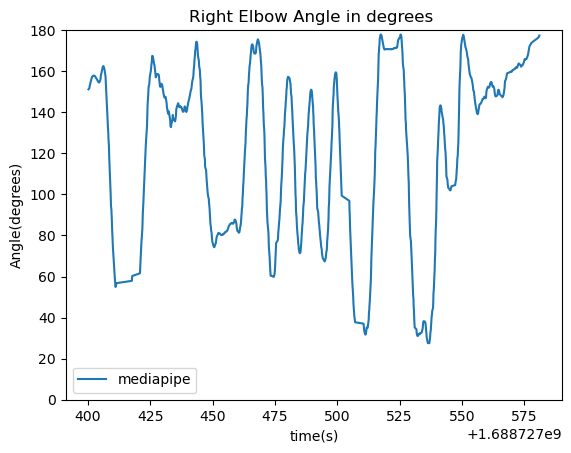

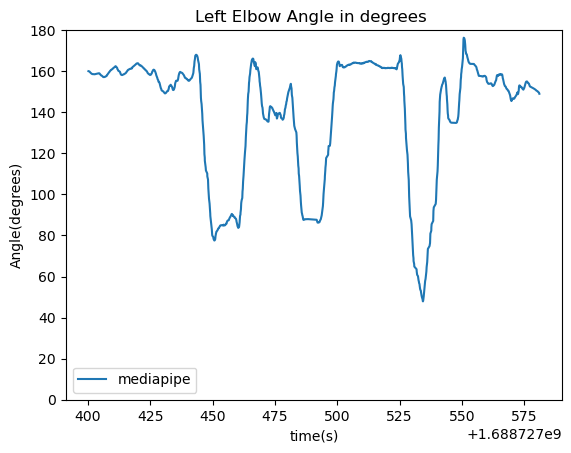

<Figure size 640x480 with 0 Axes>

In [4]:
# graph right elbow angle 
pvt_mpipe(mpipeRightElbowAngle,df_mpipe['epoch_time'].tolist())
plt.title('Right Elbow Angle in degrees ')
plt.ylim(0,180)

# Save the graph to an in-memory buffer
buffer = BytesIO()
plt.savefig(buffer, format='png')
buffer.seek(0)

plt.show()

# Clear the figure for the next graph
plt.clf()

#test graph left elbow angle 
pvt_mpipe(mpipeLeftElbowAngle,df_mpipe['epoch_time'].tolist())
plt.title('Left Elbow Angle in degrees ')
plt.ylim(0,180)

# Save the graph to an in-memory buffer
buffer = BytesIO()
plt.savefig(buffer, format='png')
buffer.seek(0)

plt.show()

# Clear the figure for the next graph
plt.clf()

In [5]:
def shoulder_frame(S,E,W):
    """"
        Find the vectors describing the local x,y,z axes of shoulder
    Parameters
    ----------
    S : shoulder point
    E : elbow point
    W : wrist point
        
    Returns
    -------
    numpy.ndarray
        An array of orthonormal vectors, where each column represents a vector.
    """
    try:
        S,E,W=np.array(S),np.array(E),np.array(W)
        upperarm=E-S
        lowerarm=W-E

        y=upperarm
        x=-np.cross(upperarm,lowerarm)
        z=np.cross(x,y)
        return np.array([x,y,z]).T
    except:
        return np .array([[np.nan,np.nan,np.nan],[np.nan,np.nan,np.nan],[np.nan,np.nan,np.nan]])

def tr_frame(LS,RS,TR):
    """"
        Find the vectors describing the local x,y,z axes of trunk
    Parameters
    ----------
    LS : left shoulder point
    RS : right shoulder point
    TR : trunk/chest point
    
    Returns
    -------
    numpy.ndarray
        An array of orthonormal vectors, where each column represents a vector.
    """
    try:
        LS,RS,TR=np.array(LS),np.array(RS),np.array(TR)

        v1=LS-RS
        v2=TR-RS

        basis=gram_schmidt([v1,v2])
        try:
            v1,v2=basis[0],basis[1]
        except:
            return np.nan
        v3=np.cross(v1,v2)

        return np.array([v1,v2,v3]).T

    except:
        return np .array([[np.nan,np.nan,np.nan],[np.nan,np.nan,np.nan],[np.nan,np.nan,np.nan]])

def gram_schmidt(vectors):
    """
        Orthonormalize a set of vectors using the Gram-Schmidt process.

    Parameters
    ----------
    vectors : list of numpy.ndarray
        A list of vectors to be orthonormalized.

    Returns
    -------
    numpy.ndarray
        An array of orthonormal vectors, where each row represents a vector.
    """
    basis = []
    for v in vectors:
        w = v - sum(np.dot(v,b)*b for b in basis)
        if (w > 1e-10).any():
            basis.append(w/np.linalg.norm(w))
    return np.array(basis)


def rotation_matrix(frame1, frame2):
    """
    Calculate the rotation matrix that transforms frame1 to frame2.
    :param frame1: 3x3 numpy array representing the first coordinate frame
    :param frame2: 3x3 numpy array representing the second coordinate frame
    :return: 3x3 numpy array representing the rotation matrix
    """
    try:
        R = np.dot(frame2, np.linalg.inv(frame1))
        return R
    except:
        return np .array([[np.nan,np.nan,np.nan],[np.nan,np.nan,np.nan],[np.nan,np.nan,np.nan]])

In [6]:
# callibrating shoulders and trunk

RSC_mpipe=shoulder_frame([df_mpipe['RS_x'][mpipe_cf],df_mpipe['RS_y'][mpipe_cf],df_mpipe['RS_z'][mpipe_cf]],
                         [df_mpipe['RE_x'][mpipe_cf],df_mpipe['RE_y'][mpipe_cf],df_mpipe['RE_z'][mpipe_cf]],
                         [df_mpipe['RW_x'][mpipe_cf],df_mpipe['RW_y'][mpipe_cf],df_mpipe['RW_z'][mpipe_cf]])

LSC_mpipe=shoulder_frame([df_mpipe['LS_x'][mpipe_cf],df_mpipe['LS_y'][mpipe_cf],df_mpipe['LS_z'][mpipe_cf]],
                         [df_mpipe['LE_x'][mpipe_cf],df_mpipe['LE_y'][mpipe_cf],df_mpipe['LE_z'][mpipe_cf]],
                         [df_mpipe['LW_x'][mpipe_cf],df_mpipe['LW_y'][mpipe_cf],df_mpipe['LW_z'][mpipe_cf]])

TRC_mpipe=tr_frame([df_mpipe['LS_x'][mpipe_cf],df_mpipe['LS_y'][mpipe_cf],df_mpipe['LS_z'][mpipe_cf]],
                   [df_mpipe['RS_x'][mpipe_cf],df_mpipe['RS_y'][mpipe_cf],df_mpipe['RS_z'][mpipe_cf]],
                   [df_mpipe['TR_x'][mpipe_cf],df_mpipe['TR_y'][mpipe_cf],df_mpipe['TR_z'][mpipe_cf]])



In [7]:
# calculating the euler angles

# Elbow Angle threshold for calculating internal/external rotation angle
eath=160

# mpipe values
mpipeRSFE,mpipeRSAA,mpipeRSIE=[],[],[]
mpipeLSFE,mpipeLSAA,mpipeLSIE=[],[],[]
mpipeTRFB,mpipeTRLR,mpipeTRRO=[],[],[]

for i in range(len(df_mpipe['epoch_time'].tolist())):

    # finding the ith shoulder/trunk frames
    mpipeRSF=shoulder_frame([df_mpipe['RS_x'][i],df_mpipe['RS_y'][i],df_mpipe['RS_z'][i]],
                            [df_mpipe['RE_x'][i],df_mpipe['RE_y'][i],df_mpipe['RE_z'][i]],
                            [df_mpipe['RW_x'][i],df_mpipe['RW_y'][i],df_mpipe['RW_z'][i]])
   
    mpipeLSF=shoulder_frame([df_mpipe['LS_x'][i],df_mpipe['LS_y'][i],df_mpipe['LS_z'][i]],
                            [df_mpipe['LE_x'][i],df_mpipe['LE_y'][i],df_mpipe['LE_z'][i]],
                            [df_mpipe['LW_x'][i],df_mpipe['LW_y'][i],df_mpipe['LW_z'][i]])
   
    mpipeTRF=tr_frame([df_mpipe['LS_x'][i],df_mpipe['LS_y'][i],df_mpipe['LS_z'][i]],
                      [df_mpipe['RS_x'][i],df_mpipe['RS_y'][i],df_mpipe['RS_z'][i]],  
                      [df_mpipe['TR_x'][i],df_mpipe['TR_y'][i],df_mpipe['TR_z'][i]])
    
    # finding the rotation matrix from callibration trunk frame to ith trunk frame
    mpipeTR_rotmat=rotation_matrix(TRC_mpipe,mpipeTRF)

    # rotating shoulder callibration frame by same the rotation matrix
    mpipe_rotated_RS_Cframe=mpipeTR_rotmat@RSC_mpipe
    mpipe_rotated_LS_Cframe=mpipeTR_rotmat@LSC_mpipe

    # now finding rotation matrix from rotated shoulder callibration frame to ith shoulder frame
    mpipeRS_rotmat=rotation_matrix(mpipe_rotated_RS_Cframe,mpipeRSF)
    mpipeLS_rotmat=rotation_matrix(mpipe_rotated_LS_Cframe,mpipeLSF)

    # finding euler angles from rotation matrices
    RSeuler=rotation_angles(mpipeRS_rotmat)
    LSeuler=rotation_angles(mpipeLS_rotmat)
    TReuler=rotation_angles(mpipeTR_rotmat)

    # appending to angle lists
    mpipeRSFE.append(RSeuler[0])
    mpipeRSAA.append(RSeuler[1])
    if mpipeRightElbowAngle[i] < eath:
        mpipeRSIE.append(RSeuler[2])
    else:
        mpipeRSIE.append(np.nan)

    mpipeLSFE.append(LSeuler[0])
    mpipeLSAA.append(LSeuler[1])
    if mpipeLeftElbowAngle[i] < eath:
        mpipeLSIE.append(LSeuler[2])
    else:
        mpipeLSIE.append(np.nan)

    mpipeTRFB.append(TReuler[0])
    mpipeTRLR.append(TReuler[1])
    mpipeTRRO.append(TReuler[2])

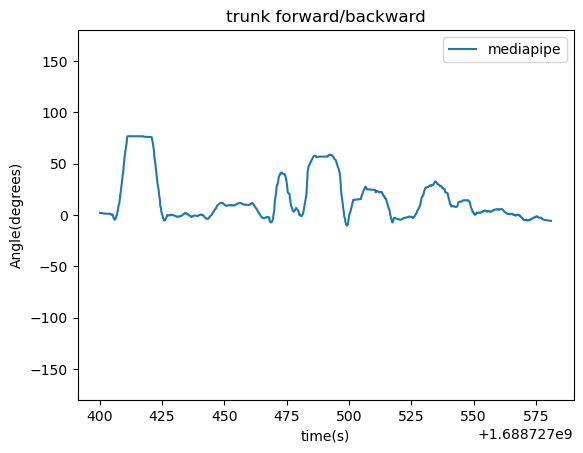

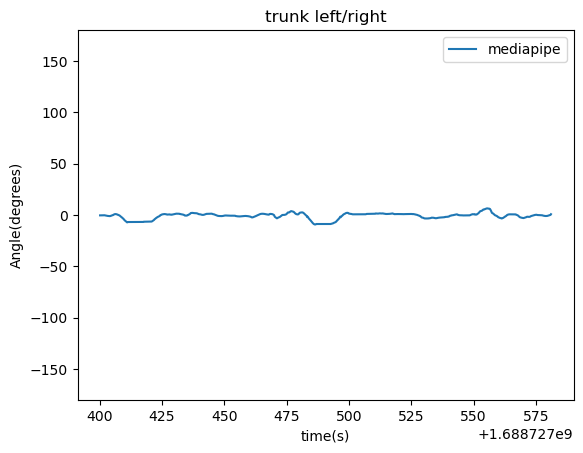

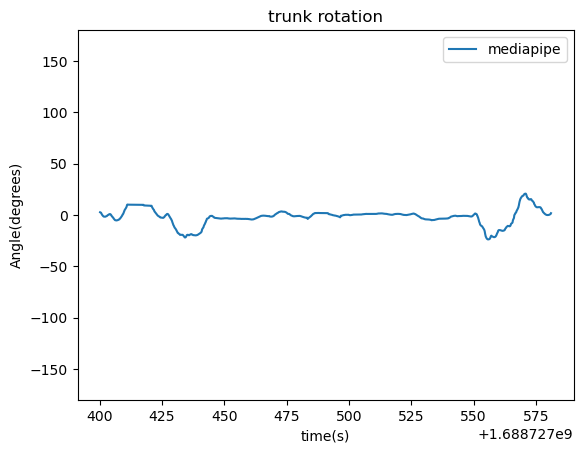

<Figure size 640x480 with 0 Axes>

In [8]:
# plotting the trunk angles
pvt_mpipe(mpipeTRFB,df_mpipe['epoch_time'].tolist())
plt.title('trunk forward/backward')
plt.ylim(-180,180)
# Save the graph to an in-memory buffer
buffer = BytesIO()
plt.savefig(buffer, format='png')
buffer.seek(0)

plt.show()

# Clear the figure for the next graph
plt.clf()


pvt_mpipe(mpipeTRLR,df_mpipe['epoch_time'].tolist())
plt.title('trunk left/right')
plt.ylim(-180,180)

# Save the graph to an in-memory buffer
buffer = BytesIO()
plt.savefig(buffer, format='png')
buffer.seek(0)

plt.show()

# Clear the figure for the next graph
plt.clf()

pvt_mpipe(mpipeTRRO,df_mpipe['epoch_time'].tolist())
plt.title('trunk rotation')
plt.ylim(-180,180)

# Save the graph to an in-memory buffer
buffer = BytesIO()
plt.savefig(buffer, format='png')
buffer.seek(0)

plt.show()

# Clear the figure for the next graph
plt.clf()

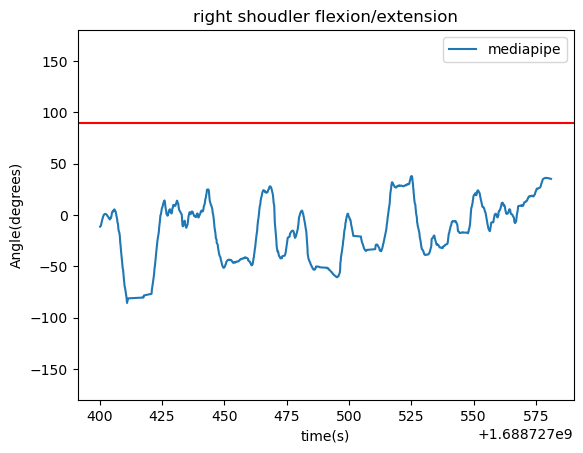

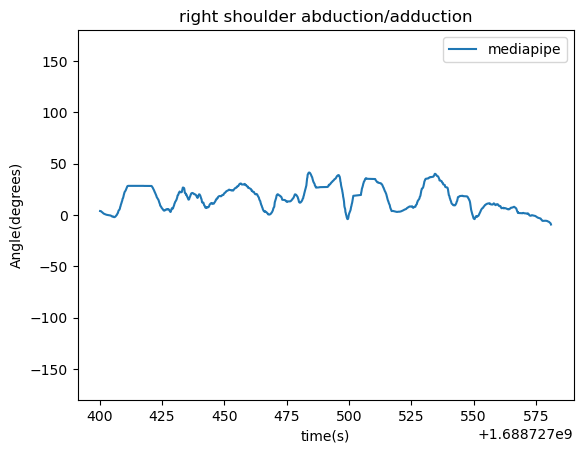

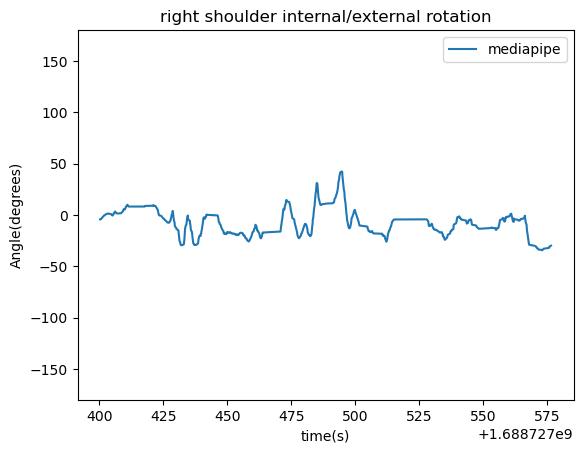

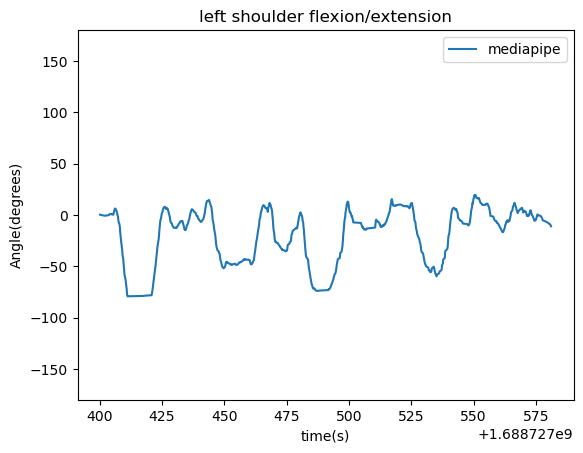

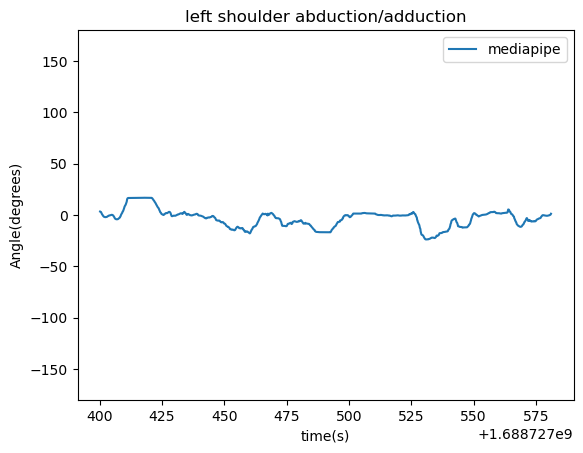

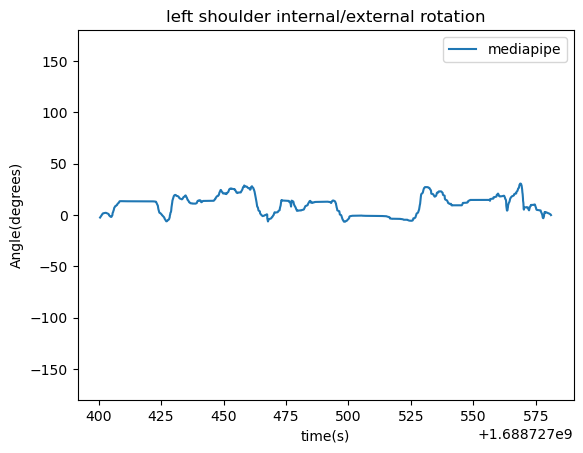

<Figure size 640x480 with 0 Axes>

In [9]:
# Plotting the shoulder angles
pvt_mpipe(mpipeRSFE,df_mpipe['epoch_time'].tolist())
plt.legend(['mediapipe','mocap'])
plt.title('right shoudler flexion/extension')
plt.ylim(-180,180)

# Save the graph to an in-memory buffer
buffer = BytesIO()
plt.savefig(buffer, format='png')
buffer.seek(0)
# draw a line at y=90
plt.axhline(y=90, color='r', linestyle='-')

plt.show()

# Clear the figure for the next graph
plt.clf()

pvt_mpipe(mpipeRSAA,df_mpipe['epoch_time'].tolist())
plt.title('right shoulder abduction/adduction')
plt.ylim(-180,180)

# Save the graph to an in-memory buffer
buffer = BytesIO()
plt.savefig(buffer, format='png')
buffer.seek(0)

plt.show()

# Clear the figure for the next graph
plt.clf()

pvt_mpipe(mpipeRSIE,df_mpipe['epoch_time'].tolist())
plt.title('right shoulder internal/external rotation')
plt.ylim(-180,180)

# Save the graph to an in-memory buffer
buffer = BytesIO()
plt.savefig(buffer, format='png')
buffer.seek(0)

plt.show()

# Clear the figure for the next graph
plt.clf()

pvt_mpipe(mpipeLSFE,df_mpipe['epoch_time'].tolist())
plt.title('left shoulder flexion/extension')
plt.ylim(-180,180)

# Save the graph to an in-memory buffer
buffer = BytesIO()
plt.savefig(buffer, format='png')
buffer.seek(0)

plt.show()

# Clear the figure for the next graph
plt.clf()

pvt_mpipe(mpipeLSAA,df_mpipe['epoch_time'].tolist())
plt.title('left shoulder abduction/adduction')
plt.ylim(-180,180)

# Save the graph to an in-memory buffer
buffer = BytesIO()
plt.savefig(buffer, format='png')
buffer.seek(0)

plt.show()

# Clear the figure for the next graph
plt.clf()

pvt_mpipe(mpipeLSIE,df_mpipe['epoch_time'].tolist())
plt.title('left shoulder internal/external rotation')
plt.ylim(-180,180)

# Save the graph to an in-memory buffer
buffer = BytesIO()
plt.savefig(buffer, format='png')
buffer.seek(0)

plt.show()

# Clear the figure for the next graph
plt.clf()

In [10]:
# # Calculate Wrist dorsifexion / volar flexion
# mpipeRightWristAngle, mpipeLeftWristAngle = [], []

# # Calculate right elbow angle using mediapipe data
# for i in range(len(df_mpipe['epoch_time'].tolist())):
#     mpipeRightWristAngle.append(angle3point([df_mpipe['RI_x'][i], df_mpipe['RI_y'][i], df_mpipe['RI_z'][i]],
#                                             [df_mpipe['RW_x'][i], df_mpipe['RW_y'][i], df_mpipe['RW_z'][i]],
#                                             [df_mpipe['RE_x'][i], df_mpipe['RE_y'][i], df_mpipe['RE_z'][i]]))
    
#     mpipeLeftWristAngle.append(angle3point([df_mpipe['LI_x'][i], df_mpipe['LI_y'][i], df_mpipe['LI_z'][i]],
#                                            [df_mpipe['LW_x'][i], df_mpipe['LW_y'][i], df_mpipe['LW_z'][i]],
#                                            [df_mpipe['LE_x'][i], df_mpipe['LE_y'][i], df_mpipe['LE_z'][i]]))



In [11]:
# # Plotting the Wrist dorsifexion / volar flexion angles
# pvt(mpipeRightWristAngle,df_mpipe['epoch_time'])
# plt.title('right Wrist dorsifexion / volar flexion')
# plt.ylim(0,180)
# plt.show()


# pvt(mpipeLeftWristAngle,df_mpipe['epoch_time'])
# plt.title('Left Wrist dorsifexion / volar flexion')
# plt.ylim(0,180)
# plt.show

In [12]:
# Calculate Pronation/supination

# setting calibration as 90 degrees pronation

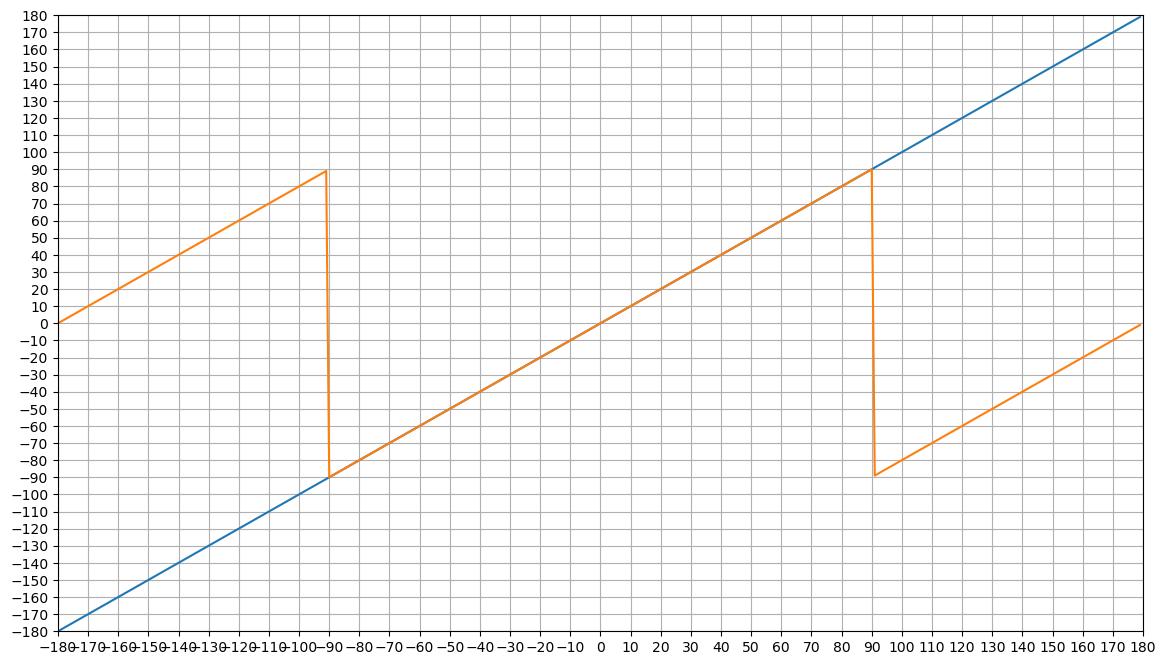

In [13]:
from matplotlib.ticker import MultipleLocator

myval = []
nval,cval=[],[]
start,stop= -180,180
for i in range(start,stop):
    myval.append(np.rad2deg(np.arctan(np.sin(np.deg2rad(i))/np.cos(np.deg2rad(i)))))

    theta=i
    c=np.tan(np.deg2rad(theta))
    theta_check = False
    if theta < 0: 
        theta_check = True 
    
    if not theta_check:

        if np.rad2deg(np.arctan(np.sin(np.deg2rad(i))/np.cos(np.deg2rad(i)))) < 0:
            cval.append(180+np.rad2deg(np.arctan(np.sin(np.deg2rad(i))/np.cos(np.deg2rad(i)))))
        else:
            cval.append(np.rad2deg(np.arctan(np.sin(np.deg2rad(i))/np.cos(np.deg2rad(i)))))
    else:

        if np.rad2deg(np.arctan(np.sin(np.deg2rad(i))/np.cos(np.deg2rad(i)))) < 0:
            cval.append(np.rad2deg(np.arctan(np.sin(np.deg2rad(i))/np.cos(np.deg2rad(i)))))
        else:
            cval.append(np.rad2deg(np.arctan(np.sin(np.deg2rad(i))/np.cos(np.deg2rad(i))))-180)

# Create a figure and an axis
fig, ax = plt.subplots(figsize=(14, 8))

# Plot the data
ax.plot(range(start,stop),cval)
ax.plot(range(start,stop),myval)

# Set the major ticks on the y-axis to be at multiples of 10
ax.yaxis.set_major_locator(MultipleLocator(10))
ax.xaxis.set_major_locator(MultipleLocator(10))

# Show the grid lines
ax.grid(True)
plt.ylim(-180,180)
plt.xlim(-180,180)
plt.show()

In [14]:
dic = {'hi': [[[1,2,3],[23,4,5]],'hi']}
print(dic['hi'][0][-1][-1])

5
